In [1]:
# Instalasi library timm untuk model Vision Transformer
!pip install timm
!pip install scikit-learn matplotlib pandas

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Cek device (gunakan GPU jika ada)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Perangkat yang digunakan: {device}")

# Konfigurasi Hyperparameter
BATCH_SIZE = 32          # [cite: 74]
EPOCHS = 1               # Ubah ke 10-20 untuk hasil lebih baik
LEARNING_RATE = 3e-4     # [cite: 74]
NUM_CLASSES = 10         # CIFAR-10 memiliki 10 kelas
IMG_SIZE = 224           # Ukuran standar input ViT

Perangkat yang digunakan: cuda


In [3]:
print("Menyiapkan Dataset CIFAR-10...")

# Transformasi: Resize ke 224x224 (wajib untuk ViT pre-trained), Normalisasi
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Download Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                        shuffle=False, num_workers=2)

classes = train_dataset.classes
print(f"Kelas: {classes}")

Menyiapkan Dataset CIFAR-10...
Kelas: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
# Fungsi untuk menghitung jumlah parameter [cite: 30-33]
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

# Fungsi Training
def train_model(model, train_loader, criterion, optimizer, num_epochs=3):
    model.train()
    history = {'loss': [], 'accuracy': []}

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 0: # Print tiap 50 batch
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_acc = 100 * correct / total
        epoch_loss = running_loss / len(train_loader)
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)

        print(f'Epoch {epoch+1} Selesai. Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, Time: {time.time()-start_time:.2f}s')

    return history

# Fungsi Evaluasi Lengkap [cite: 35-49]
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    inference_times = []

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            # Ukur waktu inferensi per batch
            start = time.time()
            outputs = model(inputs)
            end = time.time()
            inference_times.append((end - start) / len(labels)) # Waktu per gambar

            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Hitung Metrik
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    avg_inference_time = np.mean(inference_times) * 1000 # ke milidetik

    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'inference_time_ms': avg_inference_time,
        'preds': all_preds,
        'labels': all_labels
    }

In [5]:
results = {}
models_to_train = ['vit_base_patch16_224', 'swin_base_patch4_window7_224'] # [cite: 14, 15]

for model_name in models_to_train:
    print(f"\n{'='*40}")
    print(f"Mulai Training Model: {model_name}")
    print(f"{'='*40}")

    # 1. Load Pre-trained Model dari timm
    # num_classes=10 akan otomatis mengganti head classifier
    model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES)
    model = model.to(device)

    # 2. Hitung Parameter
    total_params, trainable_params = count_parameters(model)
    print(f"Total Parameter: {total_params:,}")

    # 3. Setup Training
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE) # AdamW standard untuk ViT

    # 4. Train
    train_hist = train_model(model, train_loader, criterion, optimizer, num_epochs=EPOCHS)

    # 5. Evaluate
    print(f"Mengevaluasi {model_name}...")
    metrics = evaluate_model(model, test_loader)

    # Simpan hasil
    results[model_name] = {
        'parameters': total_params,
        'metrics': metrics,
        'history': train_hist
    }

    # Bersihkan memori GPU
    del model
    torch.cuda.empty_cache()


Mulai Training Model: vit_base_patch16_224


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total Parameter: 85,806,346
Epoch [1/1], Step [1/1563], Loss: 2.5532
Epoch [1/1], Step [51/1563], Loss: 2.3642
Epoch [1/1], Step [101/1563], Loss: 1.9280
Epoch [1/1], Step [151/1563], Loss: 1.7220
Epoch [1/1], Step [201/1563], Loss: 1.4703
Epoch [1/1], Step [251/1563], Loss: 1.4853
Epoch [1/1], Step [301/1563], Loss: 1.4522
Epoch [1/1], Step [351/1563], Loss: 1.4799
Epoch [1/1], Step [401/1563], Loss: 1.6446
Epoch [1/1], Step [451/1563], Loss: 1.3378
Epoch [1/1], Step [501/1563], Loss: 1.3196
Epoch [1/1], Step [551/1563], Loss: 0.9173
Epoch [1/1], Step [601/1563], Loss: 1.3038
Epoch [1/1], Step [651/1563], Loss: 1.0619
Epoch [1/1], Step [701/1563], Loss: 0.7780
Epoch [1/1], Step [751/1563], Loss: 1.2867
Epoch [1/1], Step [801/1563], Loss: 1.2493
Epoch [1/1], Step [851/1563], Loss: 0.9021
Epoch [1/1], Step [901/1563], Loss: 0.8756
Epoch [1/1], Step [951/1563], Loss: 1.1872
Epoch [1/1], Step [1001/1563], Loss: 1.1193
Epoch [1/1], Step [1051/1563], Loss: 0.9685
Epoch [1/1], Step [1101/156

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Total Parameter: 86,753,474
Epoch [1/1], Step [1/1563], Loss: 2.2782
Epoch [1/1], Step [51/1563], Loss: 0.4398
Epoch [1/1], Step [101/1563], Loss: 0.2628
Epoch [1/1], Step [151/1563], Loss: 0.2400
Epoch [1/1], Step [201/1563], Loss: 0.3746
Epoch [1/1], Step [251/1563], Loss: 0.1651
Epoch [1/1], Step [301/1563], Loss: 0.4077
Epoch [1/1], Step [351/1563], Loss: 0.1922
Epoch [1/1], Step [401/1563], Loss: 0.1937
Epoch [1/1], Step [451/1563], Loss: 0.0678
Epoch [1/1], Step [501/1563], Loss: 0.4652
Epoch [1/1], Step [551/1563], Loss: 0.1350
Epoch [1/1], Step [601/1563], Loss: 0.1628
Epoch [1/1], Step [651/1563], Loss: 0.1974
Epoch [1/1], Step [701/1563], Loss: 0.4165
Epoch [1/1], Step [751/1563], Loss: 0.3092
Epoch [1/1], Step [801/1563], Loss: 0.1704
Epoch [1/1], Step [851/1563], Loss: 0.0586
Epoch [1/1], Step [901/1563], Loss: 0.2735
Epoch [1/1], Step [951/1563], Loss: 0.1248
Epoch [1/1], Step [1001/1563], Loss: 0.1285
Epoch [1/1], Step [1051/1563], Loss: 0.2199
Epoch [1/1], Step [1101/156


=== TABEL PERBANDINGAN MODEL ===


,Model,Params (M),Accuracy,Precision,Recall,F1-Score,Inference Time (ms/img)
0,vit_base_patch16_224,85.806346,0.6623,0.701172,0.6623,0.653325,0.368987
1,swin_base_patch4_window7_224,86.753474,0.9197,0.923808,0.9197,0.919467,1.247182


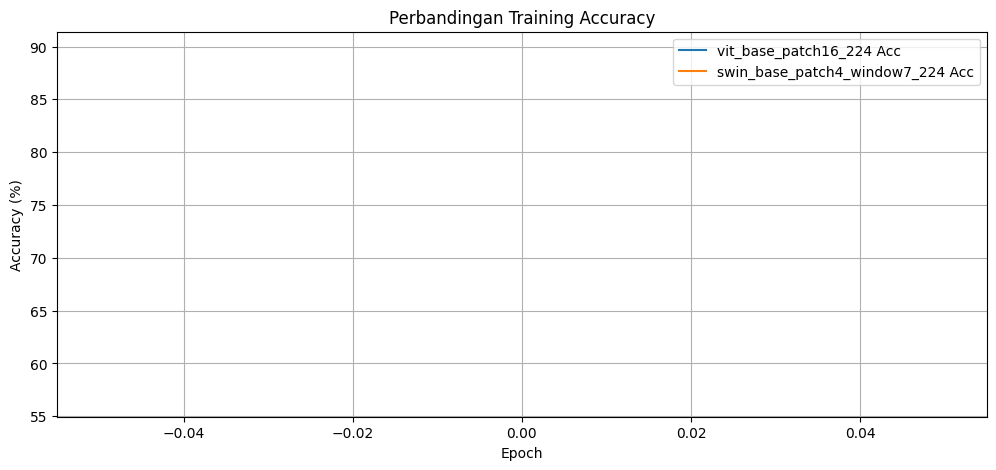

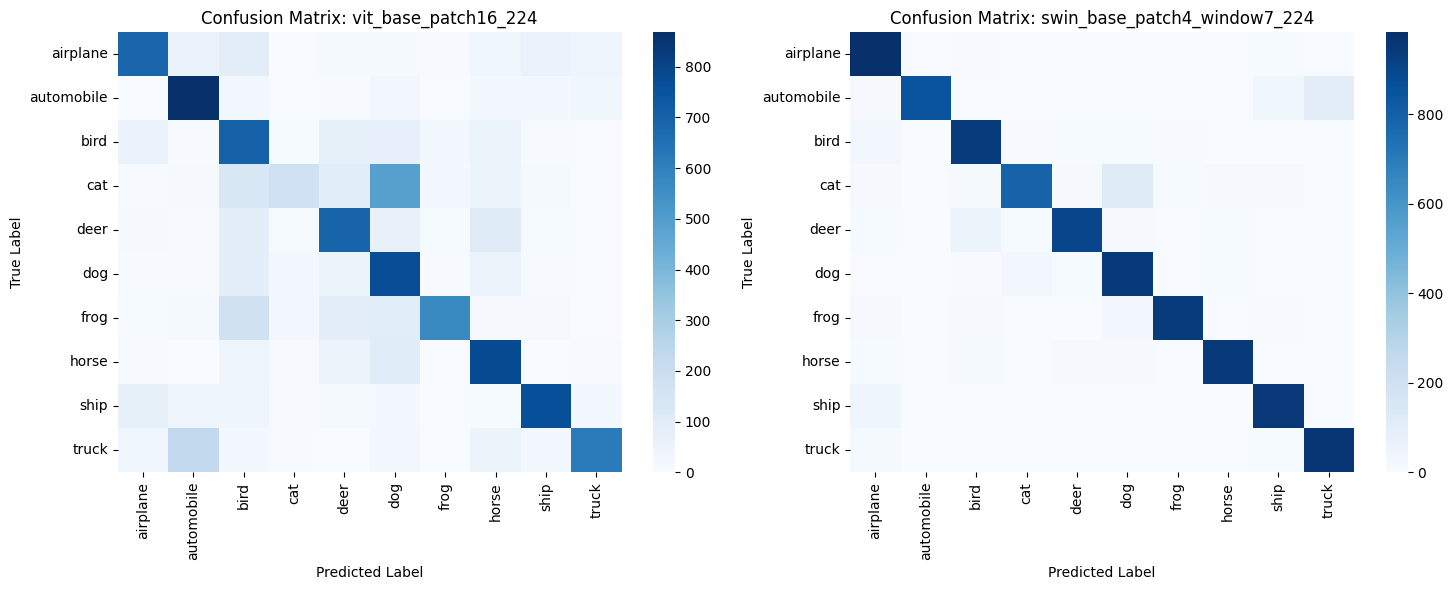

In [6]:
# 1. Tabel Perbandingan
comparison_data = []
for name, data in results.items():
    m = data['metrics']
    comparison_data.append({
        'Model': name,
        'Params (M)': data['parameters'] / 1e6,
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'F1-Score': m['f1'],
        'Inference Time (ms/img)': m['inference_time_ms']
    })

df_results = pd.DataFrame(comparison_data)
print("\n=== TABEL PERBANDINGAN MODEL ===")
display(df_results)

# 2. Plot Learning Curve
plt.figure(figsize=(12, 5))
for name, data in results.items():
    plt.plot(data['history']['accuracy'], label=f"{name} Acc")
plt.title("Perbandingan Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# 3. Plot Confusion Matrix
plt.figure(figsize=(15, 6))
for i, (name, data) in enumerate(results.items()):
    plt.subplot(1, 2, i+1)
    sns.heatmap(data['metrics']['confusion_matrix'], annot=False, cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f"Confusion Matrix: {name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()